## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q /content/drive/MyDrive/input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
! pip install warmup_scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2967 sha256=57e2a2b616b79ba538073d85e3823c54c6711c47a58206af2976cb1e43ace280
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [4]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [5]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [6]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [7]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [8]:
import segmentation_models_pytorch as smp

In [9]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [11]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/content/drive/MyDrive/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp035'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'
    #backbone = 'timm-mobilenetv3_large_100'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/content/drive/MyDrive/output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    os.makedirs(submission_dir, exist_ok=True)
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'
    os.makedirs(model_dir, exist_ok=True)

    figures_dir = outputs_path + 'figures/'
    os.makedirs(figures_dir, exist_ok=True)


    log_dir = outputs_path + 'logs/'
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    # ============== mixup =============
    mixup = True
    if mixup:
      mixup_epoch = epochs
    else:
      mixup_epoch = 0
    mixup_alpha = 0.2


set dataset path


## helper

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [14]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [15]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [16]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
INFO:__main__:

-------- exp_info -----------------


## image, mask

In [17]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #gray
        # bgr_img = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0) #BGR
        # image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV) # BGR->HSV

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #gray
    # bgr_mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0) #BGR
    # mask = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2HSV) # BGR->HSV 
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [18]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [19]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [21]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [22]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [23]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

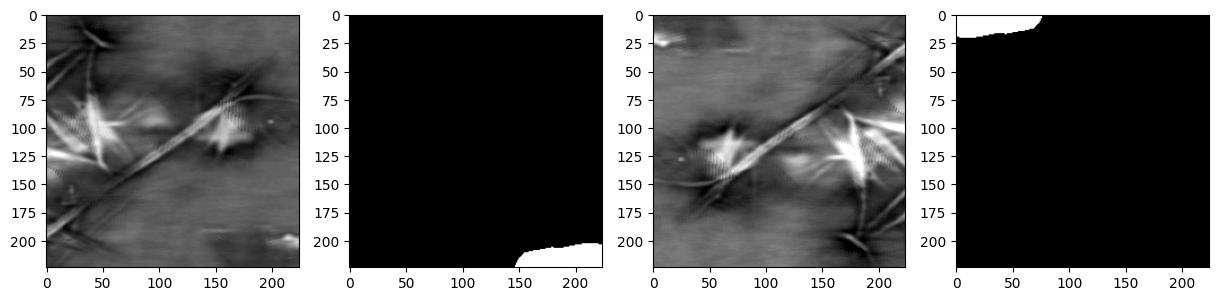

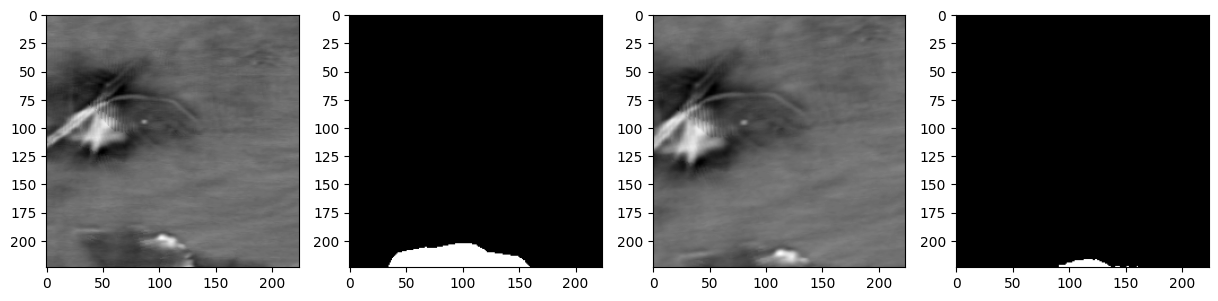

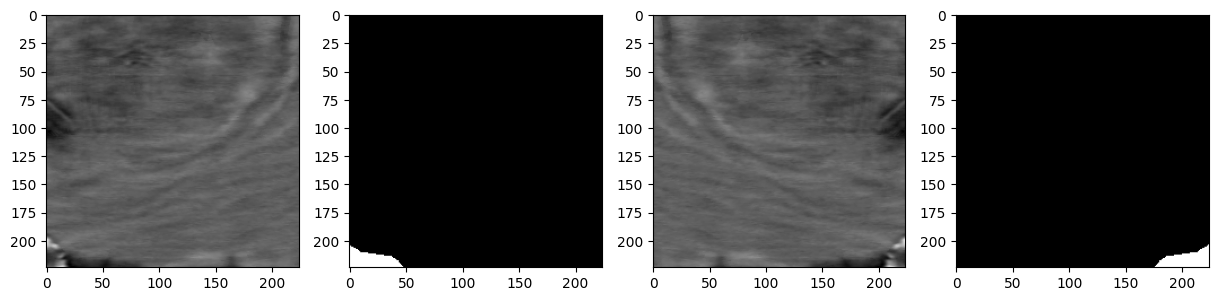

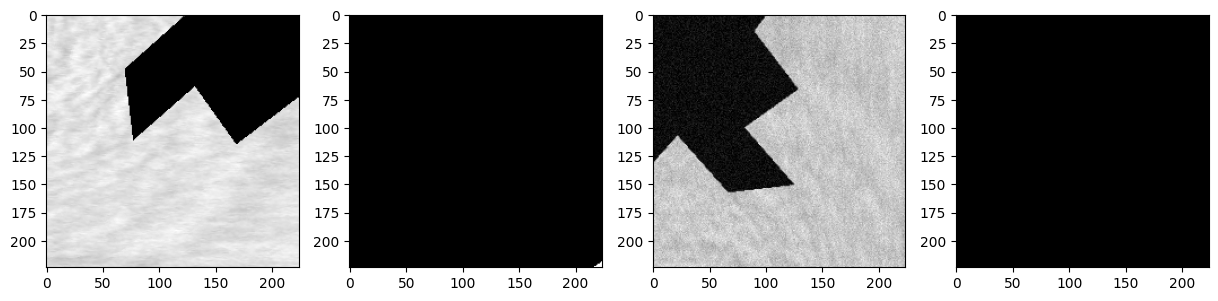

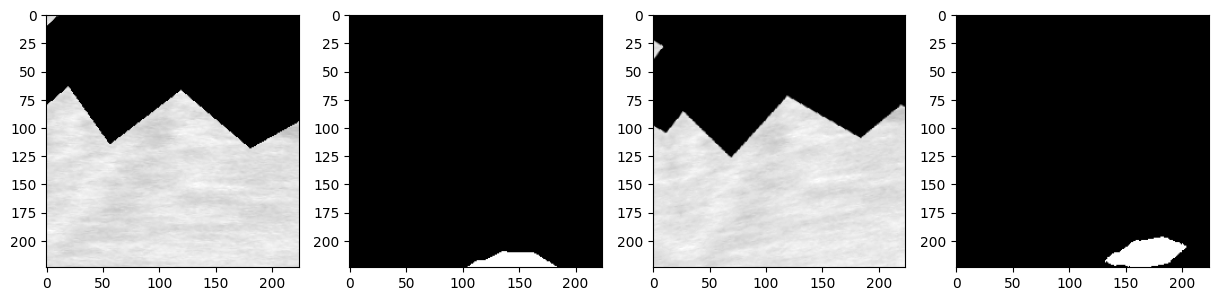

In [25]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [26]:
del plot_dataset
gc.collect()

53816

## mixup

In [27]:
def mixup_data(x, y, CFG, device):
    if CFG.mixup_alpha > 0:
        lam = np.random.beta(
            CFG.mixup_alpha, CFG.mixup_alpha
        )
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [28]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## model

In [29]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [30]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [31]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [32]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [33]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


## loss

In [34]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [35]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if CFG.mixup_epoch >= epoch:
          images, labels_a, labels_b, lam = mixup_data(images, labels, CFG, device)
          images = images.to(device)
          labels_a = labels_a.to(device)
          labels_b = labels_b.to(device)
        else:
          images = images.to(device)
          labels = labels.to(device)

        # images = images.to(device)
        # labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            if CFG.mixup_epoch >= epoch:
              loss = mixup_criterion(criterion, y_preds, labels_a, labels_b, lam)
            else:
              loss = criterion(y_preds, labels)
            
            # loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [36]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [37]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [38]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096613984941226
th: 0.15, fbeta: 0.1209830726765226
th: 0.2, fbeta: 0.12570473104183363
th: 0.25, fbeta: 0.22563302343725902
th: 0.3, fbeta: 0.2744527310615898
th: 0.35, fbeta: 0.31942904832469593
th: 0.4, fbeta: 0.3567209150914618
th: 0.45, fbeta: 0.37947753894220093


best_th: 0.45, fbeta: 0.37947753894220093
INFO:__main__:best_th: 0.45, fbeta: 0.37947753894220093
Epoch 1 - avg_train_loss: 0.5768  avg_val_loss: 0.3990  time: 487s
INFO:__main__:Epoch 1 - avg_train_loss: 0.5768  avg_val_loss: 0.3990  time: 487s
Epoch 1 - avgScore: 0.3795
INFO:__main__:Epoch 1 - avgScore: 0.3795
Epoch 1 - Save Best Score: 0.3795 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.3795 Model
Epoch 1 - Save Best Loss: 0.3990 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.3990 Model


th: 0.5, fbeta: 0.3782545882598483


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12096735594870733
th: 0.15, fbeta: 0.19867835111297216
th: 0.2, fbeta: 0.25049480917824846
th: 0.25, fbeta: 0.3097809444042529
th: 0.3, fbeta: 0.3500846365027734
th: 0.35, fbeta: 0.38334482091303207
th: 0.4, fbeta: 0.4110740093071296
th: 0.45, fbeta: 0.43266859468637753


best_th: 0.5, fbeta: 0.4411819390236859
INFO:__main__:best_th: 0.5, fbeta: 0.4411819390236859
Epoch 2 - avg_train_loss: 0.3943  avg_val_loss: 0.3346  time: 494s
INFO:__main__:Epoch 2 - avg_train_loss: 0.3943  avg_val_loss: 0.3346  time: 494s
Epoch 2 - avgScore: 0.4412
INFO:__main__:Epoch 2 - avgScore: 0.4412
Epoch 2 - Save Best Score: 0.4412 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.4412 Model
Epoch 2 - Save Best Loss: 0.3346 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.3346 Model


th: 0.5, fbeta: 0.4411819390236859


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2650007377187534
th: 0.15, fbeta: 0.30665330057925777
th: 0.2, fbeta: 0.3524396642753869
th: 0.25, fbeta: 0.3836551225847858
th: 0.3, fbeta: 0.4060006319525436
th: 0.35, fbeta: 0.4265650770151576
th: 0.4, fbeta: 0.444243037791433
th: 0.45, fbeta: 0.4547829473898544


best_th: 0.5, fbeta: 0.4627514352172281
INFO:__main__:best_th: 0.5, fbeta: 0.4627514352172281
Epoch 3 - avg_train_loss: 0.3056  avg_val_loss: 0.2493  time: 499s
INFO:__main__:Epoch 3 - avg_train_loss: 0.3056  avg_val_loss: 0.2493  time: 499s
Epoch 3 - avgScore: 0.4628
INFO:__main__:Epoch 3 - avgScore: 0.4628
Epoch 3 - Save Best Score: 0.4628 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.4628 Model
Epoch 3 - Save Best Loss: 0.2493 Model
INFO:__main__:Epoch 3 - Save Best Loss: 0.2493 Model


th: 0.5, fbeta: 0.4627514352172281


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30434020435387776
th: 0.15, fbeta: 0.3478444958045061
th: 0.2, fbeta: 0.38158687745785214
th: 0.25, fbeta: 0.41051942353484017
th: 0.3, fbeta: 0.43641285106475036
th: 0.35, fbeta: 0.4563888288762015
th: 0.4, fbeta: 0.47259557150012044
th: 0.45, fbeta: 0.48652518093760616


best_th: 0.5, fbeta: 0.4955656605401604
INFO:__main__:best_th: 0.5, fbeta: 0.4955656605401604
Epoch 4 - avg_train_loss: 0.2736  avg_val_loss: 0.2435  time: 495s
INFO:__main__:Epoch 4 - avg_train_loss: 0.2736  avg_val_loss: 0.2435  time: 495s
Epoch 4 - avgScore: 0.4956
INFO:__main__:Epoch 4 - avgScore: 0.4956
Epoch 4 - Save Best Score: 0.4956 Model
INFO:__main__:Epoch 4 - Save Best Score: 0.4956 Model
Epoch 4 - Save Best Loss: 0.2435 Model
INFO:__main__:Epoch 4 - Save Best Loss: 0.2435 Model


th: 0.5, fbeta: 0.4955656605401604


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33282979527075196
th: 0.15, fbeta: 0.3683713030303921
th: 0.2, fbeta: 0.3913494333150015
th: 0.25, fbeta: 0.40739820945379307
th: 0.3, fbeta: 0.4188420687996822
th: 0.35, fbeta: 0.42238155163066743
th: 0.4, fbeta: 0.4188483422659988
th: 0.45, fbeta: 0.40572599632365874


best_th: 0.35, fbeta: 0.42238155163066743
INFO:__main__:best_th: 0.35, fbeta: 0.42238155163066743
Epoch 5 - avg_train_loss: 0.2618  avg_val_loss: 0.2486  time: 531s
INFO:__main__:Epoch 5 - avg_train_loss: 0.2618  avg_val_loss: 0.2486  time: 531s
Epoch 5 - avgScore: 0.4224
INFO:__main__:Epoch 5 - avgScore: 0.4224


th: 0.5, fbeta: 0.37380344295801227


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35786368943450425
th: 0.15, fbeta: 0.39791589017209206
th: 0.2, fbeta: 0.4285858735507481
th: 0.25, fbeta: 0.4563194134115508
th: 0.3, fbeta: 0.4757603779940017
th: 0.35, fbeta: 0.4902170338414386
th: 0.4, fbeta: 0.5001949219506657
th: 0.45, fbeta: 0.49420381746696224


best_th: 0.4, fbeta: 0.5001949219506657
INFO:__main__:best_th: 0.4, fbeta: 0.5001949219506657
Epoch 6 - avg_train_loss: 0.2516  avg_val_loss: 0.2386  time: 540s
INFO:__main__:Epoch 6 - avg_train_loss: 0.2516  avg_val_loss: 0.2386  time: 540s
Epoch 6 - avgScore: 0.5002
INFO:__main__:Epoch 6 - avgScore: 0.5002
Epoch 6 - Save Best Score: 0.5002 Model
INFO:__main__:Epoch 6 - Save Best Score: 0.5002 Model
Epoch 6 - Save Best Loss: 0.2386 Model
INFO:__main__:Epoch 6 - Save Best Loss: 0.2386 Model


th: 0.5, fbeta: 0.4725952836282717


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3234949704777559
th: 0.15, fbeta: 0.3561560701015924
th: 0.2, fbeta: 0.38440393632347136
th: 0.25, fbeta: 0.4115853294162849
th: 0.3, fbeta: 0.4364464949997126
th: 0.35, fbeta: 0.458598089860352
th: 0.4, fbeta: 0.47945466204320014
th: 0.45, fbeta: 0.5002208068055135


best_th: 0.5, fbeta: 0.5183859715914005
INFO:__main__:best_th: 0.5, fbeta: 0.5183859715914005
Epoch 7 - avg_train_loss: 0.2445  avg_val_loss: 0.2279  time: 528s
INFO:__main__:Epoch 7 - avg_train_loss: 0.2445  avg_val_loss: 0.2279  time: 528s
Epoch 7 - avgScore: 0.5184
INFO:__main__:Epoch 7 - avgScore: 0.5184
Epoch 7 - Save Best Score: 0.5184 Model
INFO:__main__:Epoch 7 - Save Best Score: 0.5184 Model
Epoch 7 - Save Best Loss: 0.2279 Model
INFO:__main__:Epoch 7 - Save Best Loss: 0.2279 Model


th: 0.5, fbeta: 0.5183859715914005


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38771533671592845
th: 0.15, fbeta: 0.4326192736085503
th: 0.2, fbeta: 0.4654713388840559
th: 0.25, fbeta: 0.49225159343791774
th: 0.3, fbeta: 0.5136245087372726
th: 0.35, fbeta: 0.5326971769193172
th: 0.4, fbeta: 0.544822648192727
th: 0.45, fbeta: 0.5503341513636848


best_th: 0.5, fbeta: 0.5522057274742892
INFO:__main__:best_th: 0.5, fbeta: 0.5522057274742892
Epoch 8 - avg_train_loss: 0.2306  avg_val_loss: 0.2313  time: 513s
INFO:__main__:Epoch 8 - avg_train_loss: 0.2306  avg_val_loss: 0.2313  time: 513s
Epoch 8 - avgScore: 0.5522
INFO:__main__:Epoch 8 - avgScore: 0.5522
Epoch 8 - Save Best Score: 0.5522 Model
INFO:__main__:Epoch 8 - Save Best Score: 0.5522 Model
Epoch 8 - Save Best Loss: 0.2313 Model
INFO:__main__:Epoch 8 - Save Best Loss: 0.2313 Model


th: 0.5, fbeta: 0.5522057274742892


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3859498651366562
th: 0.15, fbeta: 0.4237393413570959
th: 0.2, fbeta: 0.4553273107205905
th: 0.25, fbeta: 0.48250942890428034
th: 0.3, fbeta: 0.5064865764216692
th: 0.35, fbeta: 0.5269070446721897
th: 0.4, fbeta: 0.5389720503711286
th: 0.45, fbeta: 0.5454072162669411


best_th: 0.5, fbeta: 0.54972717806826
INFO:__main__:best_th: 0.5, fbeta: 0.54972717806826
Epoch 9 - avg_train_loss: 0.2241  avg_val_loss: 0.2217  time: 538s
INFO:__main__:Epoch 9 - avg_train_loss: 0.2241  avg_val_loss: 0.2217  time: 538s
Epoch 9 - avgScore: 0.5497
INFO:__main__:Epoch 9 - avgScore: 0.5497


th: 0.5, fbeta: 0.54972717806826


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3563954665243177
th: 0.15, fbeta: 0.3793696814326249
th: 0.2, fbeta: 0.3973406770646449
th: 0.25, fbeta: 0.41180018339544655
th: 0.3, fbeta: 0.4239009511784334
th: 0.35, fbeta: 0.4359235039022732
th: 0.4, fbeta: 0.44571850118006623
th: 0.45, fbeta: 0.4533121705882212


best_th: 0.5, fbeta: 0.4605067461719796
INFO:__main__:best_th: 0.5, fbeta: 0.4605067461719796
Epoch 10 - avg_train_loss: 0.2112  avg_val_loss: 0.2551  time: 565s
INFO:__main__:Epoch 10 - avg_train_loss: 0.2112  avg_val_loss: 0.2551  time: 565s
Epoch 10 - avgScore: 0.4605
INFO:__main__:Epoch 10 - avgScore: 0.4605


th: 0.5, fbeta: 0.4605067461719796


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3570484448883941
th: 0.15, fbeta: 0.3944889083983066
th: 0.2, fbeta: 0.4249917359356597
th: 0.25, fbeta: 0.4486185931457927
th: 0.3, fbeta: 0.46688544644086927
th: 0.35, fbeta: 0.48755034997744445
th: 0.4, fbeta: 0.5084442461966913
th: 0.45, fbeta: 0.524119126216135


best_th: 0.5, fbeta: 0.5352316569383173
INFO:__main__:best_th: 0.5, fbeta: 0.5352316569383173
Epoch 11 - avg_train_loss: 0.2035  avg_val_loss: 0.2340  time: 583s
INFO:__main__:Epoch 11 - avg_train_loss: 0.2035  avg_val_loss: 0.2340  time: 583s
Epoch 11 - avgScore: 0.5352
INFO:__main__:Epoch 11 - avgScore: 0.5352


th: 0.5, fbeta: 0.5352316569383173


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3568091159173784
th: 0.15, fbeta: 0.39516841028890554
th: 0.2, fbeta: 0.42630983968396857
th: 0.25, fbeta: 0.4525226119033019
th: 0.3, fbeta: 0.4739843104128938
th: 0.35, fbeta: 0.4926501267516955
th: 0.4, fbeta: 0.5085391171949212
th: 0.45, fbeta: 0.5204632473929608


best_th: 0.5, fbeta: 0.5291138976325761
INFO:__main__:best_th: 0.5, fbeta: 0.5291138976325761
Epoch 12 - avg_train_loss: 0.1949  avg_val_loss: 0.2357  time: 590s
INFO:__main__:Epoch 12 - avg_train_loss: 0.1949  avg_val_loss: 0.2357  time: 590s
Epoch 12 - avgScore: 0.5291
INFO:__main__:Epoch 12 - avgScore: 0.5291


th: 0.5, fbeta: 0.5291138976325761


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39938901659450593
th: 0.15, fbeta: 0.44138704476566226
th: 0.2, fbeta: 0.46740212605766496
th: 0.25, fbeta: 0.4874414992521501
th: 0.3, fbeta: 0.5042577344555798
th: 0.35, fbeta: 0.5180376413255814
th: 0.4, fbeta: 0.5257737535542858
th: 0.45, fbeta: 0.527911370243042


best_th: 0.45, fbeta: 0.527911370243042
INFO:__main__:best_th: 0.45, fbeta: 0.527911370243042
Epoch 13 - avg_train_loss: 0.1880  avg_val_loss: 0.2471  time: 591s
INFO:__main__:Epoch 13 - avg_train_loss: 0.1880  avg_val_loss: 0.2471  time: 591s
Epoch 13 - avgScore: 0.5279
INFO:__main__:Epoch 13 - avgScore: 0.5279


th: 0.5, fbeta: 0.5229324374481061


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34893090473180344
th: 0.15, fbeta: 0.37655397283557157
th: 0.2, fbeta: 0.39663546967575425
th: 0.25, fbeta: 0.4162287078766208
th: 0.3, fbeta: 0.436062859103914
th: 0.35, fbeta: 0.4534542710621306
th: 0.4, fbeta: 0.4684081262859378
th: 0.45, fbeta: 0.47944700751824826


best_th: 0.5, fbeta: 0.4852617898463698
INFO:__main__:best_th: 0.5, fbeta: 0.4852617898463698
Epoch 14 - avg_train_loss: 0.1787  avg_val_loss: 0.2490  time: 629s
INFO:__main__:Epoch 14 - avg_train_loss: 0.1787  avg_val_loss: 0.2490  time: 629s
Epoch 14 - avgScore: 0.4853
INFO:__main__:Epoch 14 - avgScore: 0.4853


th: 0.5, fbeta: 0.4852617898463698


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3832788542049322
th: 0.15, fbeta: 0.4177639754205832
th: 0.2, fbeta: 0.44304048535425633
th: 0.25, fbeta: 0.46371609510253164
th: 0.3, fbeta: 0.4792669754946791
th: 0.35, fbeta: 0.4941601372533549
th: 0.4, fbeta: 0.5079932635771799
th: 0.45, fbeta: 0.5179407506096809


best_th: 0.5, fbeta: 0.5254562555019916
INFO:__main__:best_th: 0.5, fbeta: 0.5254562555019916
Epoch 15 - avg_train_loss: 0.1756  avg_val_loss: 0.2480  time: 619s
INFO:__main__:Epoch 15 - avg_train_loss: 0.1756  avg_val_loss: 0.2480  time: 619s
Epoch 15 - avgScore: 0.5255
INFO:__main__:Epoch 15 - avgScore: 0.5255


th: 0.5, fbeta: 0.5254562555019916


In [39]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [40]:
mask_pred = check_point['preds']

In [41]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.38771533671592845
th: 0.15, fbeta: 0.4326192736085503
th: 0.2, fbeta: 0.4654713388840559
th: 0.25, fbeta: 0.49225159343791774
th: 0.3, fbeta: 0.5136245087372726
th: 0.35, fbeta: 0.5326971769193172
th: 0.4, fbeta: 0.544822648192727
th: 0.45, fbeta: 0.5503341513636848


best_th: 0.5, fbeta: 0.5522057274742892
INFO:__main__:best_th: 0.5, fbeta: 0.5522057274742892


th: 0.5, fbeta: 0.5522057274742892


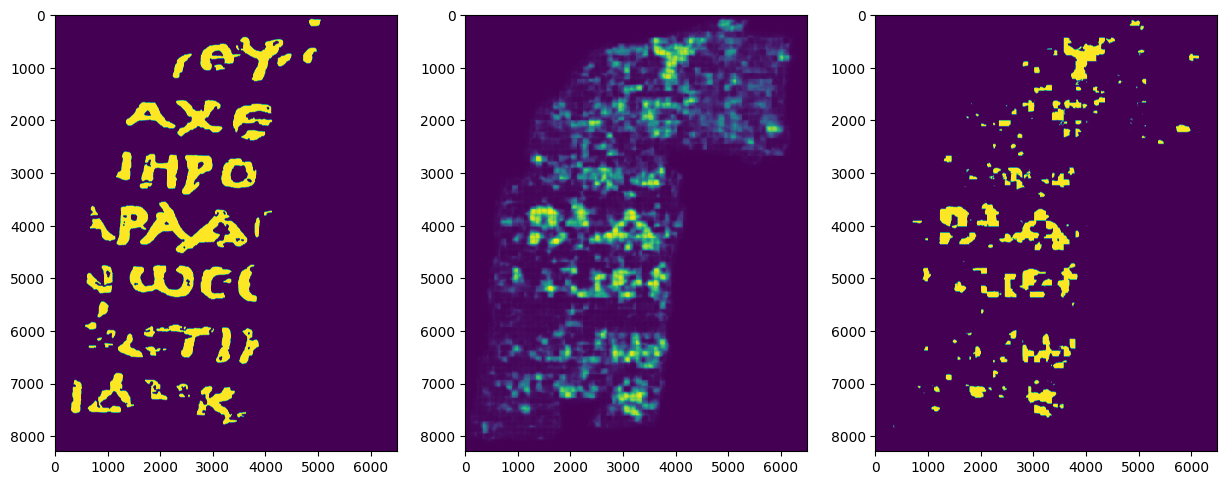

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([37730058.,  4444450.,  2503278.,  1682331.,  1246154.,   953688.,
          779181.,   659191.,   599213.,   541017.,   433833.,   358757.,
          309618.,   298272.,   307214.,   304519.,   276642.,   219921.,
          147563.,    43948.]),
 array([1.09611831e-05, 4.95111110e-02, 9.90112608e-02, 1.48511411e-01,
        1.98011560e-01, 2.47511710e-01, 2.97011860e-01, 3.46512010e-01,
        3.96012160e-01, 4.45512309e-01, 4.95012459e-01, 5.44512609e-01,
        5.94012759e-01, 6.43512908e-01, 6.93013058e-01, 7.42513208e-01,
        7.92013358e-01, 8.41513508e-01, 8.91013657e-01, 9.40513807e-01,
        9.90013957e-01]),
 <BarContainer object of 20 artists>)

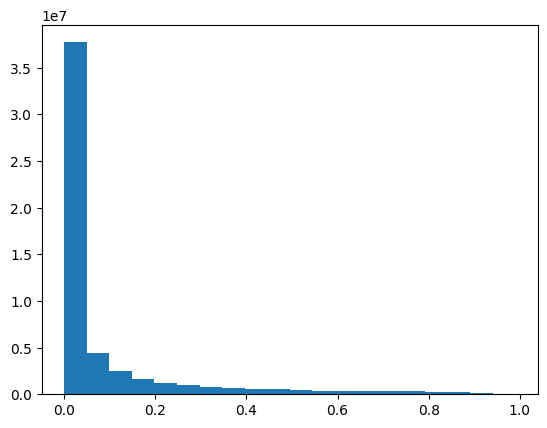

In [43]:
plt.hist(mask_pred.flatten(), bins=20)